In [1]:
'''Import all the necessary packages'''
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

### 분석의 개요 및 목적

-주어진 Data Set 을 통해 집값에 미치는 요인들을 분석하여 러시아 집값을 예측해본다.  

### 분석의 방법 및 범위





###### EDA(탐색적 자료 분석)

- 변수 탐색 및 데이터의 이해.
- 도메인 지식 확보 및 변수별 정의.
- 산점도 확인. 
- 변수 별 상관관계 확인.

###### Preprocessing(전처리)

* 데이터 중복 제거.
* 변수 스케일링.
* 아웃라이어 탐색.

###### Model Selection(회귀 모델 설정)

* 회귀 분석 후 변수 최종 선택 및 모델 설정.
* 크로스 밸리데이션.
* 회귀 모델군 상호 평가.

### EDA
주어진 Data Set
- train.csv : 21570rows, 292columns
- test.csw : 8901rows, 291columns
- macro.csv : 2484rows, 100coumns 

#### Macro는 적용 안 하기로 결정

In [2]:
'''Import the train and test data set'''
data_train = pd.read_csv('train.csv')
data_train.shape

(21570, 292)

### Column name preprocessing 
R style 모형에서는 '-'가 설명변수 제거라는 의미를 가지고 있기 때문에 잘못 읽히는 것을 방지하기 위해 이름을 바꾸었다.
* https://www.tutorialspoint.com/python/string_replace.htm -참조

In [3]:
def convert_column(data_train):
    data_train_columns = list(data_train.columns.values)
    for i in range(len(data_train_columns)):
        if '-' in data_train_columns[i]:
            data_train_columns[i] = data_train_columns[i].replace('-', '_')
    return data_train_columns

In [4]:
'''Some of the column names contain - signs which crashes the OLS algorithm'''
'''https://www.tutorialspoint.com/python/string_replace.htm'''
data_train_columns = convert_column(data_train)
data_train.columns = data_train_columns

X = data_train.iloc[:, 2:291]
y = data_train.iloc[:, 291]

### 데이터 분포 시각화

### Null Data 갯수 확인

In [5]:
'''This variable is used to check how much data is missing'''
missing_data_count = data_train.isnull().sum()
missing_data_count

id                                           0
timestamp                                    0
full_sq                                      0
life_sq                                   4539
floor                                      124
max_floor                                 6773
material                                  6773
build_year                                9621
num_room                                  6773
kitch_sq                                  6773
state                                     9600
product_type                                 0
sub_area                                     0
area_m                                       0
raion_popul                                  0
green_zone_part                              0
indust_part                                  0
children_preschool                           0
preschool_quota                           4720
preschool_education_centers_raion            0
children_school                              0
school_quota 

### 카테고리 데이터 분석
카테고리값 Encoding 하는 중에 직관적으로 말이 되지 않는 변수들은 nan 값으로 처리하였다.

In [6]:
def label_encoding(X):
    '''Label Encoding and mapping'''
    
    #sub_area encoding
    sub_area_le = LabelEncoder()
    X['sub_area'] = sub_area_le.fit_transform(X['sub_area'])
    
    #product_type encoding
    product_type_le = LabelEncoder()
    X['product_type'] = product_type_le.fit_transform(X['product_type'])
    
    #All the yes_no encoding
    yes_no_le = LabelEncoder()
    yes_no_list = ['thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
       'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 
       'water_1line', 'big_road1_1line', 'railroad_1line', 'culture_objects_top_25']
    for column in yes_no_list:
        X[column] = yes_no_le.fit_transform(X[column])
    
    #ecology mapping
    X['ecology'].unique()
    ecology_mapping = {'excellent' : 4, 'good' : 3, 'satisfactory' : 2, 'poor' : 1, 'no data' : np.nan}
    X['ecology'] = X['ecology'].map(ecology_mapping)
    
    encoder_dict = {'sub_area' : sub_area_le, 'product_type' : product_type_le, 'yes_no' : yes_no_le,
                    'ecology' : ecology_mapping}  
    return X, encoder_dict

def simple_filter(X):
    X.loc[ (X.build_year > 2015) | (X.build_year < 1600 ), 'build_year'] = np.nan
    X.loc[ (X.state > 4) | (X.state < 1), 'state'] = np.nan
    return X

In [7]:
'''Perform encoding and mapping'''
X, encoder_dict = label_encoding(data_train.iloc[:, 2:])

'''Drop all the data with nan terms'''
X_drop = X.dropna()
print(X_drop.shape)

'''Data description'''
data_describe = X_drop.describe()

'''build_year and state obviously need some modification'''
X_drop = simple_filter(X_drop)

(4218, 290)


C:\Users\cck3\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
X_drop.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
5696,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,0,...,339,135,26,133,207,1,89,161,10,2750000
5864,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,2.0,0,...,214,85,21,48,89,1,54,146,12,11700000
5936,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,3.0,0,...,99,43,8,17,41,1,18,93,5,6200000
5951,43,27.0,1.0,5.0,2.0,1960.0,2.0,5.0,2.0,0,...,24,4,0,20,40,0,10,101,7,5950000
5962,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,0,...,7,4,0,9,15,0,0,42,3,5900000


### Encoding 후에도 발생한 nan 값을 drop 처리 

* https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame -참조

In [9]:
X_drop = X_drop.dropna().reset_index(drop = True)
data_describe = X_drop.describe()
X_drop.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,0,...,339,135,26,133,207,1,89,161,10,2750000
1,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,2.0,0,...,214,85,21,48,89,1,54,146,12,11700000
2,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,3.0,0,...,99,43,8,17,41,1,18,93,5,6200000
3,43,27.0,1.0,5.0,2.0,1960.0,2.0,5.0,2.0,0,...,24,4,0,20,40,0,10,101,7,5950000
4,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,0,...,7,4,0,9,15,0,0,42,3,5900000


In [10]:
X_drop.tail()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
4105,38,19.0,7.0,17.0,1.0,2006.0,1.0,7.0,3.0,0,...,26,12,0,8,23,1,4,67,2,6800000
4106,54,32.0,8.0,16.0,1.0,1979.0,2.0,9.0,2.0,0,...,8,0,0,6,25,0,1,32,8,9500000
4107,56,29.0,13.0,14.0,1.0,2001.0,2.0,11.0,3.0,0,...,14,2,0,13,12,0,1,53,6,12000000
4108,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,0,...,22,1,1,6,31,1,4,65,7,13500000
4109,43,28.0,1.0,9.0,1.0,1968.0,2.0,6.0,2.0,0,...,5,2,0,7,16,0,9,54,10,5600000


In [11]:
X_drop.shape

(4110, 290)

### NaN 값, 상식적으로 말이 안되는 데이터 처리 후: 21570 데이터 -> 4110 데이터 

### 남아있는 String 값 확인
Encoding 후에도 Stiring 값이 남아있을 경우를 대비해서 확인하였다.
* https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas -참조

In [12]:
print(X_drop[~X_drop.applymap(np.isreal).all(1)])

Empty DataFrame
Columns: [full_sq, life_sq, floor, max_floor, material, build_year, num_room, kitch_sq, state, product_type, sub_area, area_m, raion_popul, green_zone_part, indust_part, children_preschool, preschool_quota, preschool_education_centers_raion, children_school, school_quota, school_education_centers_raion, school_education_centers_top_20_raion, hospital_beds_raion, healthcare_centers_raion, university_top_20_raion, sport_objects_raion, additional_education_raion, culture_objects_top_25, culture_objects_top_25_raion, shopping_centers_raion, office_raion, thermal_power_plant_raion, incineration_raion, oil_chemistry_raion, radiation_raion, railroad_terminal_raion, big_market_raion, nuclear_reactor_raion, detention_facility_raion, full_all, male_f, female_f, young_all, young_male, young_female, work_all, work_male, work_female, ekder_all, ekder_male, ekder_female, 0_6_all, 0_6_male, 0_6_female, 7_14_all, 7_14_male, 7_14_female, 0_17_all, 0_17_male, 0_17_female, 16_29_all, 16_2

### 각각의 Data 종류별로 재분류

- Nominal Values 비연속적인 카테고리값
- Ordinal Values 연속적인 카테고리값
- Target Value  Y값
- Numerical Values 숫자값

### 데이터 Scaling및 추가 전 처리시 쉽게 확인할수 있음

In [13]:
#Nominal category values
nom_categorical_list =['material', 'product_type', 'sub_area', 'ID_metro', 'ID_railroad_station_walk',
                   'ID_railroad_station_avto', 'ID_big_road1', 
                   'ID_big_road2', 'ID_railroad_terminal', 'ID_bus_terminal',  
                   'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
                   'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                   'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 
                   'culture_objects_top_25']

#Ordinal category values
ord_categorical_list = ['state', 'ecology']

#target/y values
target = 'price_doc'

#Numerical values 
filter_list = nom_categorical_list + ord_categorical_list + [target]
numeric_list = list(X_drop.columns)
for item in filter_list:
    numeric_list.remove(item)
    
    
'''Filter out categorical values that I will not be using'''
nom_categorical_list =['material', 'product_type', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 
                       'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                       'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'culture_objects_top_25']
    
'''Re-partitioning the DataFrame numeric -> ord_cat -> nom_cat -> target'''
X_drop = pd.concat([X_drop[numeric_list], X_drop[ord_categorical_list], 
                    X_drop[nom_categorical_list], X_drop[target]], axis = 1)
X_drop.tail()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,culture_objects_top_25,price_doc
4105,38,19.0,7.0,17.0,2006.0,1.0,7.0,1.752651e+07,118843,0.133373,...,0,0,0,0,0,0,0,0,0,6800000
4106,54,32.0,8.0,16.0,1979.0,2.0,9.0,2.481385e+07,174831,0.683844,...,1,0,0,0,0,0,0,0,0,9500000
4107,56,29.0,13.0,14.0,2001.0,2.0,11.0,9.249237e+06,156377,0.374068,...,0,0,0,0,0,0,0,0,0,12000000
4108,64,32.0,5.0,15.0,2003.0,2.0,11.0,6.050065e+06,78616,0.167526,...,1,0,0,0,0,0,0,0,0,13500000
4109,43,28.0,1.0,9.0,1968.0,2.0,6.0,4.395333e+06,94561,0.063755,...,1,0,0,0,0,0,0,0,0,5600000


In [14]:
X_drop.shape

(4110, 282)

### VIF(Variance Inflation Factor)

* VIF를 하기위해 위에서 정의한 숫자값과 연속적인 카테고리값을 표준화한다 
* 연속적인 카테고리값에 경우, 같은 간격을 가진 변수라는 것을 증명하지 못하므로 표준화하지 않는다 

* https://learnandteachstatistics.wordpress.com/2013/07/08/ordinal/
https://www.ma.utexas.edu/users/mks/statmistakes/ordinal.html
https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf      - 참조

In [15]:
'''Apply scaling to numeric value and declare a variable for the new standardized matrix'''
sc = StandardScaler()
X_drop_sc = X_drop[:]
X_drop_sc[numeric_list] = sc.fit_transform(X_drop_sc[numeric_list])

### 높은 상관관계를 가진 변수 탐색

* http://support.minitab.com/en-us/minitab/17/topic-library/modeling-statistics/regression-and-correlation/model-assumptions/what-is-a-variance-inflation-factor-vif/ -참조

In [16]:
def VIF_analysis(X):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

In [17]:
vif_metro = VIF_analysis(X_drop_sc[['metro_min_avto', 'metro_km_avto', 'metro_km_walk', 'metro_min_walk']])
vif_railroad = VIF_analysis(X_drop_sc[['railroad_station_avto_min', 'railroad_station_avto_km', 
                                       'railroad_station_walk_min', 'railroad_station_walk_km']])
vif_population = VIF_analysis(X_drop_sc[['raion_popul', 'children_school', 'children_preschool', 'full_all', 'male_f', 
                           'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 
                           'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', 
                           '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', 
                           '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male',
                           '0_13_female']])

In [18]:
vif_metro.head()

,VIF Factor,features
0,7.736992,metro_min_avto
1,13.625832,metro_km_avto
2,inf,metro_km_walk
3,inf,metro_min_walk


In [19]:
vif_railroad.head()

,VIF Factor,features
0,12.742023,railroad_station_avto_min
1,21.461014,railroad_station_avto_km
2,inf,railroad_station_walk_min
3,inf,railroad_station_walk_km


In [20]:
vif_population = vif_population.sort_values('VIF Factor')
vif_population

,VIF Factor,features
1,3.174656e+03,children_school
4,9.562069e+03,male_f
0,1.207460e+04,raion_popul
6,8.586304e+04,young_all
11,1.007305e+05,work_female
9,1.690628e+05,work_all
7,1.512942e+06,young_male
8,3.362107e+06,young_female
19,inf,7_14_male
26,inf,16_29_female


In [21]:
'''Based on VIF analysis following features will be dropped'''
vif_delete_list = list(vif_metro.loc[vif_metro['VIF Factor'] > 10, 'features']) + \
                  list(vif_population.loc[vif_population['VIF Factor'] > 10**7 , 'features']) + \
                  list(vif_railroad.loc[vif_railroad['VIF Factor'] > 20, 'features'])

In [22]:
print(len(vif_delete_list))
print(vif_delete_list)

28
['metro_km_avto', 'metro_km_walk', 'metro_min_walk', '7_14_male', '16_29_female', '16_29_all', '0_13_all', '0_17_female', '0_17_male', '0_17_all', '7_14_female', '16_29_male', '7_14_all', 'ekder_female', '0_6_male', '0_6_all', '0_13_male', 'ekder_male', 'ekder_all', 'work_male', 'female_f', 'full_all', 'children_preschool', '0_6_female', '0_13_female', 'railroad_station_avto_km', 'railroad_station_walk_min', 'railroad_station_walk_km']


### 높은 상관관계를 가진 변수 제거
numeric_list에서 Vif_delete_list drop 후에 282개의 변수에서 254개의 변수로 줄어든 것을 확인
* https://stackoverflow.com/questions/28538536/deleting-multiple-columns-in-pandas -참조

In [23]:
X_drop_sc.drop(vif_delete_list, axis = 1, inplace = True)
numeric_list_vif = numeric_list[:]
for item in vif_delete_list:
    numeric_list_vif.remove(item)
    
X_drop.drop(vif_delete_list, axis = 1, inplace = True)

In [24]:
X_drop.shape

(4110, 254)

### OLS 에 사용될 Feature Matrix는 254개의 인자와 4110개의 데이터 보유

### R style dmatrix encoding 형식에 맞게 변수 재정의

In [25]:
'''Compile a string that will be fed into sm.OLS.from_formula'''
'''Handling numeric and ord categorical information. Add this too!'''
numeric_ord_cat_OLS_string = " + ".join(numeric_list_vif + ord_categorical_list)

'''Handling the nominal categorical information with C()'''
category_OLS_string = "C(material)"

'''yes no categorical values don't need to be separately encoded'''
yes_no_list = ['thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
                   'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 
                   'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 
                   'culture_objects_top_25', 'product_type']
yes_no_OLS_string = " + ".join(yes_no_list)

'''This is the total string'''
OLS_string = numeric_ord_cat_OLS_string + " + " + category_OLS_string + " + " + yes_no_OLS_string

In [26]:
print(OLS_string)

full_sq + life_sq + floor + max_floor + build_year + num_room + kitch_sq + area_m + raion_popul + green_zone_part + indust_part + preschool_quota + preschool_education_centers_raion + children_school + school_quota + school_education_centers_raion + school_education_centers_top_20_raion + hospital_beds_raion + healthcare_centers_raion + university_top_20_raion + sport_objects_raion + additional_education_raion + culture_objects_top_25_raion + shopping_centers_raion + office_raion + male_f + young_all + young_male + young_female + work_all + work_female + raion_build_count_with_material_info + build_count_block + build_count_wood + build_count_frame + build_count_brick + build_count_monolith + build_count_panel + build_count_foam + build_count_slag + build_count_mix + raion_build_count_with_builddate_info + build_count_before_1920 + build_count_1921_1945 + build_count_1946_1970 + build_count_1971_1995 + build_count_after_1995 + metro_min_avto + kindergarten_km + school_km + park_km + gr

In [27]:
'''Create a dmatrix for encoding and extract the column variables so they can
be used to access features with low p values'''
'''https://stackoverflow.com/questions/23560104/fetching-names-from-designmatrix-in-patsy'''
dfX = dmatrix(OLS_string, data = X_drop)
dfX_columns = dfX.design_info.column_names
dfX = pd.DataFrame(dfX, columns = dfX_columns)

dfY = pd.DataFrame(X_drop_sc['price_doc'])

dfX.tail()

,Intercept,C(material)[T.2.0],C(material)[T.4.0],C(material)[T.5.0],C(material)[T.6.0],full_sq,life_sq,floor,max_floor,build_year,...,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,culture_objects_top_25,product_type
4105,1.0,0.0,0.0,0.0,0.0,38.0,19.0,7.0,17.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4106,1.0,0.0,0.0,0.0,0.0,54.0,32.0,8.0,16.0,1979.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4107,1.0,0.0,0.0,0.0,0.0,56.0,29.0,13.0,14.0,2001.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4108,1.0,0.0,0.0,0.0,0.0,64.0,32.0,5.0,15.0,2003.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4109,1.0,0.0,0.0,0.0,0.0,43.0,28.0,1.0,9.0,1968.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
dfX.shape

(4110, 257)

# OLS 분석을 통한 p-value 값 확인

## 1차 Run

In [29]:
model = sm.OLS(dfY, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     27.69
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -68064.
No. Observations:                4110   AIC:                         1.366e+05
Df Residuals:                    3864   BIC:                         1.382e+05
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

## Confidence Interval (1%) P-value test를 통과하지 못한 인자 전처리 과정

In [30]:
def p_value_extract(result, confidence):
    '''https://stackoverflow.com/questions/37787698/how-to-sort-pandas-dataframe-from-one-column'''
    p_values = pd.DataFrame(result.pvalues)
    p_values.columns = ['p_value']
    p_values['p_value'] = p_values[p_values.p_value < confidence]
    p_values = p_values.dropna().sort_values('p_value')
    return p_values

In [31]:
p = p_value_extract(result, 0.01)
extracted_feature = list(p.index.values)
print('The number of extracted features is: ', len(extracted_feature))
dfX_extract = dfX.loc[:, extracted_feature]
dfX_extract.tail()

The number of extracted features is:  18


,full_sq,state,leisure_count_1500,cafe_count_1500_price_4000,leisure_count_2000,kitch_sq,floor,life_sq,cafe_count_1500_price_high,thermal_power_plant_km,office_sqm_1500,metro_min_avto,product_type,cafe_count_1000_price_1000,big_market_km,church_synagogue_km,leisure_count_500,max_floor
4105,38.0,3.0,0.0,0.0,0.0,7.0,7.0,19.0,0.0,1.425857,174000.0,5.183068,0.0,1.0,11.167425,1.549102,0.0,17.0
4106,54.0,2.0,0.0,0.0,0.0,9.0,8.0,32.0,0.0,6.655360,0.0,1.817750,0.0,3.0,4.845983,1.139177,0.0,16.0
4107,56.0,3.0,1.0,0.0,1.0,11.0,13.0,29.0,0.0,5.721404,9881.0,2.622565,0.0,1.0,20.481457,2.040548,0.0,14.0
4108,64.0,2.0,0.0,0.0,2.0,11.0,5.0,32.0,0.0,6.417997,37800.0,3.377814,0.0,6.0,2.515959,0.476021,0.0,15.0
4109,43.0,2.0,4.0,0.0,5.0,6.0,1.0,28.0,0.0,5.239948,0.0,0.584636,0.0,6.0,14.028112,0.867332,4.0,9.0


In [32]:
dfX2 = sm.add_constant(dfX_extract)
dfX2.tail()

,const,full_sq,state,leisure_count_1500,cafe_count_1500_price_4000,leisure_count_2000,kitch_sq,floor,life_sq,cafe_count_1500_price_high,thermal_power_plant_km,office_sqm_1500,metro_min_avto,product_type,cafe_count_1000_price_1000,big_market_km,church_synagogue_km,leisure_count_500,max_floor
4105,1,38.0,3.0,0.0,0.0,0.0,7.0,7.0,19.0,0.0,1.425857,174000.0,5.183068,0.0,1.0,11.167425,1.549102,0.0,17.0
4106,1,54.0,2.0,0.0,0.0,0.0,9.0,8.0,32.0,0.0,6.655360,0.0,1.817750,0.0,3.0,4.845983,1.139177,0.0,16.0
4107,1,56.0,3.0,1.0,0.0,1.0,11.0,13.0,29.0,0.0,5.721404,9881.0,2.622565,0.0,1.0,20.481457,2.040548,0.0,14.0
4108,1,64.0,2.0,0.0,0.0,2.0,11.0,5.0,32.0,0.0,6.417997,37800.0,3.377814,0.0,6.0,2.515959,0.476021,0.0,15.0
4109,1,43.0,2.0,4.0,0.0,5.0,6.0,1.0,28.0,0.0,5.239948,0.0,0.584636,0.0,6.0,14.028112,0.867332,4.0,9.0


In [33]:
dfX2.shape

(4110, 19)

## 2차 Run

In [34]:
model2 = sm.OLS(dfY, dfX2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     301.9
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -68410.
No. Observations:                4110   AIC:                         1.369e+05
Df Residuals:                    4091   BIC:                         1.370e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
const               

In [35]:
p2 = p_value_extract(result2, 0.01)
extracted_feature2 = list(p2.index.values)
print('The number of extracted features is: ', len(extracted_feature2))
dfX_extract2 = dfX2.loc[:, extracted_feature2]
dfX_extract2.tail()

The number of extracted features is:  16


,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,state,cafe_count_1500_price_4000,life_sq,const,kitch_sq,church_synagogue_km,product_type,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500
4105,38.0,0.0,0.0,0.0,3.0,0.0,19.0,1,7.0,1.549102,0.0,1.0,1.425857,5.183068,7.0,0.0
4106,54.0,0.0,0.0,0.0,2.0,0.0,32.0,1,9.0,1.139177,0.0,3.0,6.655360,1.817750,8.0,0.0
4107,56.0,0.0,1.0,1.0,3.0,0.0,29.0,1,11.0,2.040548,0.0,1.0,5.721404,2.622565,13.0,0.0
4108,64.0,0.0,0.0,2.0,2.0,0.0,32.0,1,11.0,0.476021,0.0,6.0,6.417997,3.377814,5.0,0.0
4109,43.0,0.0,4.0,5.0,2.0,0.0,28.0,1,6.0,0.867332,0.0,6.0,5.239948,0.584636,1.0,4.0


In [36]:
#Not sure why but constants are added at some random location.....
dfX3 = sm.add_constant(dfX_extract2)
dfX3.tail()

,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,state,cafe_count_1500_price_4000,life_sq,const,kitch_sq,church_synagogue_km,product_type,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500
4105,38.0,0.0,0.0,0.0,3.0,0.0,19.0,1,7.0,1.549102,0.0,1.0,1.425857,5.183068,7.0,0.0
4106,54.0,0.0,0.0,0.0,2.0,0.0,32.0,1,9.0,1.139177,0.0,3.0,6.655360,1.817750,8.0,0.0
4107,56.0,0.0,1.0,1.0,3.0,0.0,29.0,1,11.0,2.040548,0.0,1.0,5.721404,2.622565,13.0,0.0
4108,64.0,0.0,0.0,2.0,2.0,0.0,32.0,1,11.0,0.476021,0.0,6.0,6.417997,3.377814,5.0,0.0
4109,43.0,0.0,4.0,5.0,2.0,0.0,28.0,1,6.0,0.867332,0.0,6.0,5.239948,0.584636,1.0,4.0


In [37]:
dfX3.shape

(4110, 16)

## 3차 Run

In [38]:
model3 = sm.OLS(dfY, dfX3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     361.6
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -68413.
No. Observations:                4110   AIC:                         1.369e+05
Df Residuals:                    4094   BIC:                         1.370e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

### P-value filtration 통해 select된 인자 list

In [39]:
OLS_feature_extracted = list(dfX3.columns.values)
print(OLS_feature_extracted)

['full_sq', 'cafe_count_1500_price_high', 'leisure_count_1500', 'leisure_count_2000', 'state', 'cafe_count_1500_price_4000', 'life_sq', 'const', 'kitch_sq', 'church_synagogue_km', 'product_type', 'cafe_count_1000_price_1000', 'thermal_power_plant_km', 'metro_min_avto', 'floor', 'leisure_count_500']


## Outlier 제거

In [40]:
def outlier_crusher(result):
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(dfY) - dfX2.shape[1] - 1)
    idx = np.where(cooks_d2 > fox_cr)[0]
    return idx

In [41]:
idx = outlier_crusher(result3)
print(idx)
print()
print('There are {} outliers according to Fox criteria.'.format(len(idx)))

[   0   22   24   29   49   55   65   82   90  108  140  169  215  218  237
  245  262  290  295  322  330  337  371  373  376  406  411  433  440  445
  484  539  548  558  585  602  603  615  657  713  716  718  749  761  816
  879  940  960  967  991 1008 1025 1134 1152 1170 1177 1221 1232 1265 1271
 1279 1282 1326 1335 1347 1349 1387 1407 1409 1421 1449 1451 1455 1464 1467
 1479 1485 1488 1496 1506 1524 1534 1537 1554 1556 1566 1568 1590 1614 1619
 1627 1631 1633 1637 1647 1663 1667 1680 1681 1684 1745 1755 1764 1769 1801
 1805 1809 1832 1843 1845 1864 1897 1909 1924 1926 1986 1995 2007 2029 2032
 2041 2049 2070 2086 2087 2143 2150 2157 2158 2166 2247 2256 2257 2328 2384
 2414 2418 2443 2454 2474 2505 2519 2520 2544 2574 2587 2604 2607 2660 2666
 2684 2688 2689 2690 2707 2717 2724 2730 2737 2742 2778 2807 2817 2830 2841
 2857 2869 2923 2934 2981 2983 2992 3006 3017 3023 3025 3057 3092 3126 3132
 3138 3145 3157 3172 3173 3213 3229 3233 3237 3242 3243 3247 3319 3351 3360
 3363 3374 3

In [42]:
dfX3_idx = dfX3.drop(idx)
dfY_idx = dfY.drop(idx)

print(dfX3_idx.shape)
print(dfY_idx.shape)

(3863, 16)
(3863, 1)


## Outlier 제거 후 OLS 분석

In [43]:
dfX3_idx_c = sm.add_constant(dfX3_idx)

model_idx_c = sm.OLS(dfY_idx, dfX3_idx_c)
result_idx_c = model_idx_c.fit()
print(result_idx_c.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     400.3
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -62664.
No. Observations:                3863   AIC:                         1.254e+05
Df Residuals:                    3847   BIC:                         1.255e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

## Scaling과 Test set, Traing set 분리

* https://stats.stackexchange.com/questions/160902/is-it-possible-for-test-error-to-be-lower-than-training-error -참조

In [44]:
def num_cat_divider(X, feature):
    X_numeric, X_cat = [], []
    for item in feature:
        if item == 'state':
            X_cat.append(item)
        elif len(X[item].unique()) > 2:
            X_numeric.append(item)
        else:
            X_cat.append(item)
    return X[X_numeric], X[X_cat]

In [45]:
'''Now apply train_test analysis on OLS using exracted features after scaling
the necessary features. The split should be around 7:3 ratio, and make sure to
include stratified option'''

'''dfX2 is now our non-scaled feature matrix with dfY being the dependent variable
vector. First repartition dfX2 into numerical and categorical parts'''
dfX3_train, dfX3_test, dfY_train, dfY_test = train_test_split(dfX3_idx_c, dfY_idx, test_size = 0.2, random_state = 0)


'''
#Split into numerical anc categorical parts'''
dfX3_train_numeric, dfX3_train_cat = num_cat_divider(dfX3_train, OLS_feature_extracted)
dfX3_test_numeric, dfX3_test_cat = num_cat_divider(dfX3_test, OLS_feature_extracted)
#Index saved for later proprocessing
dfX3_train_index = list(dfX3_train_numeric.index.values)
dfX3_test_index = list(dfX3_test_numeric.index.values)


sc_dfx3 = StandardScaler()
dfX3_train_numeric_sc = pd.DataFrame(sc_dfx3.fit_transform(dfX3_train_numeric), 
                                     columns = dfX3_train_numeric.columns.values, index=dfX3_train_index)
dfX3_test_numeric_sc = pd.DataFrame(sc_dfx3.transform(dfX3_test_numeric), 
                                    columns = dfX3_test_numeric.columns.values, index=dfX3_test_index)

dfX3_train_sc = pd.concat([dfX3_train_numeric_sc, dfX3_train_cat], axis = 1)
dfX3_test_sc = pd.concat([dfX3_test_numeric_sc, dfX3_test_cat], axis = 1)

print(dfX3_train_sc.shape)
print(dfY_train.shape)

(3090, 16)
(3090, 1)


In [46]:
dfX3_train_cat.head()

,state,const,product_type
1334,3.0,1,0.0
432,3.0,1,0.0
2995,4.0,1,0.0
3853,2.0,1,0.0
3223,3.0,1,0.0


In [47]:
print(dfX3_test_sc.shape)
print(dfY_test.shape)

(773, 16)
(773, 1)


In [48]:
dfX3_train_sc.tail()

,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,cafe_count_1500_price_4000,life_sq,kitch_sq,church_synagogue_km,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500,state,const,product_type
881,-0.342078,-0.260628,-0.402874,-0.226268,-0.271422,-1.023332,1.080391,-0.728184,0.028093,0.873853,0.753517,0.586899,-0.262663,2.0,1,0.0
3467,-0.342078,-0.260628,-0.402874,-0.383138,-0.271422,-0.267013,-0.856041,0.280364,-0.573908,1.488557,-0.799666,0.586899,-0.262663,3.0,1,0.0
1754,0.851717,-0.260628,-0.081615,-0.069398,-0.271422,1.169994,-0.081468,-0.754343,0.630095,-0.765662,-0.258731,-0.507560,-0.262663,3.0,1,0.0
2767,-1.137941,-0.260628,-0.081615,-0.069398,-0.094929,-1.401492,0.305818,1.441620,-0.092307,-1.681577,0.203656,-1.164236,-0.262663,3.0,1,0.0
2899,0.340091,-0.260628,-0.402874,-0.383138,-0.271422,0.489307,-0.856041,1.435582,-0.092307,-0.423392,-1.143320,-0.288668,-0.262663,2.0,1,0.0


## Scaling한 Training dataset 으로 OLS 분석

In [49]:
'''OLS run for train and test runs respectively'''
model_train = sm.OLS(dfY_train, dfX3_train_sc)
result_train = model_train.fit()
print(result_train.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     322.9
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:58   Log-Likelihood:                -50102.
No. Observations:                3090   AIC:                         1.002e+05
Df Residuals:                    3074   BIC:                         1.003e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

### P-value test 통과하지 못한 인자 추가제거

In [50]:
del dfX3_train_sc['life_sq']
del dfX3_train_sc['leisure_count_500']

del dfX3_test_sc['life_sq']
del dfX3_test_sc['leisure_count_500']

In [51]:
dfX3_train_sc.shape

(3090, 14)

In [52]:
dfX3_test_sc.shape

(773, 14)

In [53]:
'''OLS run for train and test runs respectively'''
model_train2 = sm.OLS(dfY_train, dfX3_train_sc)
result_train2 = model_train2.fit()
print(result_train2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     370.4
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:59:59   Log-Likelihood:                -50108.
No. Observations:                3090   AIC:                         1.002e+05
Df Residuals:                    3076   BIC:                         1.003e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

## Residual plot, Partial Regression plot, and CCPR

* http://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html -참조

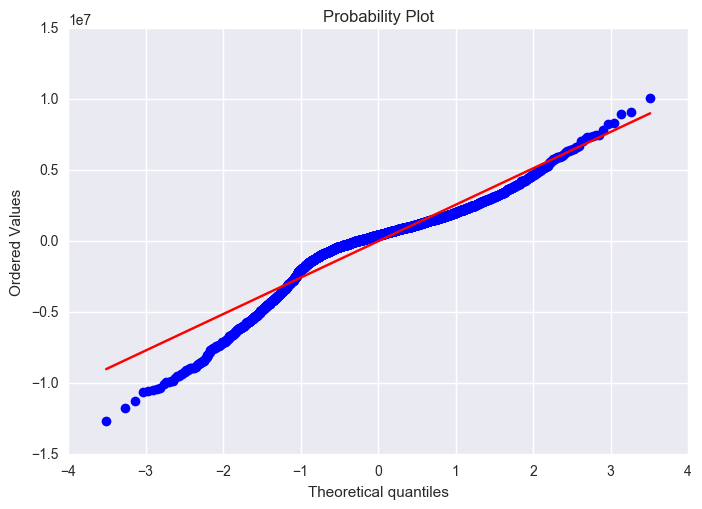

In [54]:
stats.probplot(result_train2.resid, plot=plt)
plt.show()

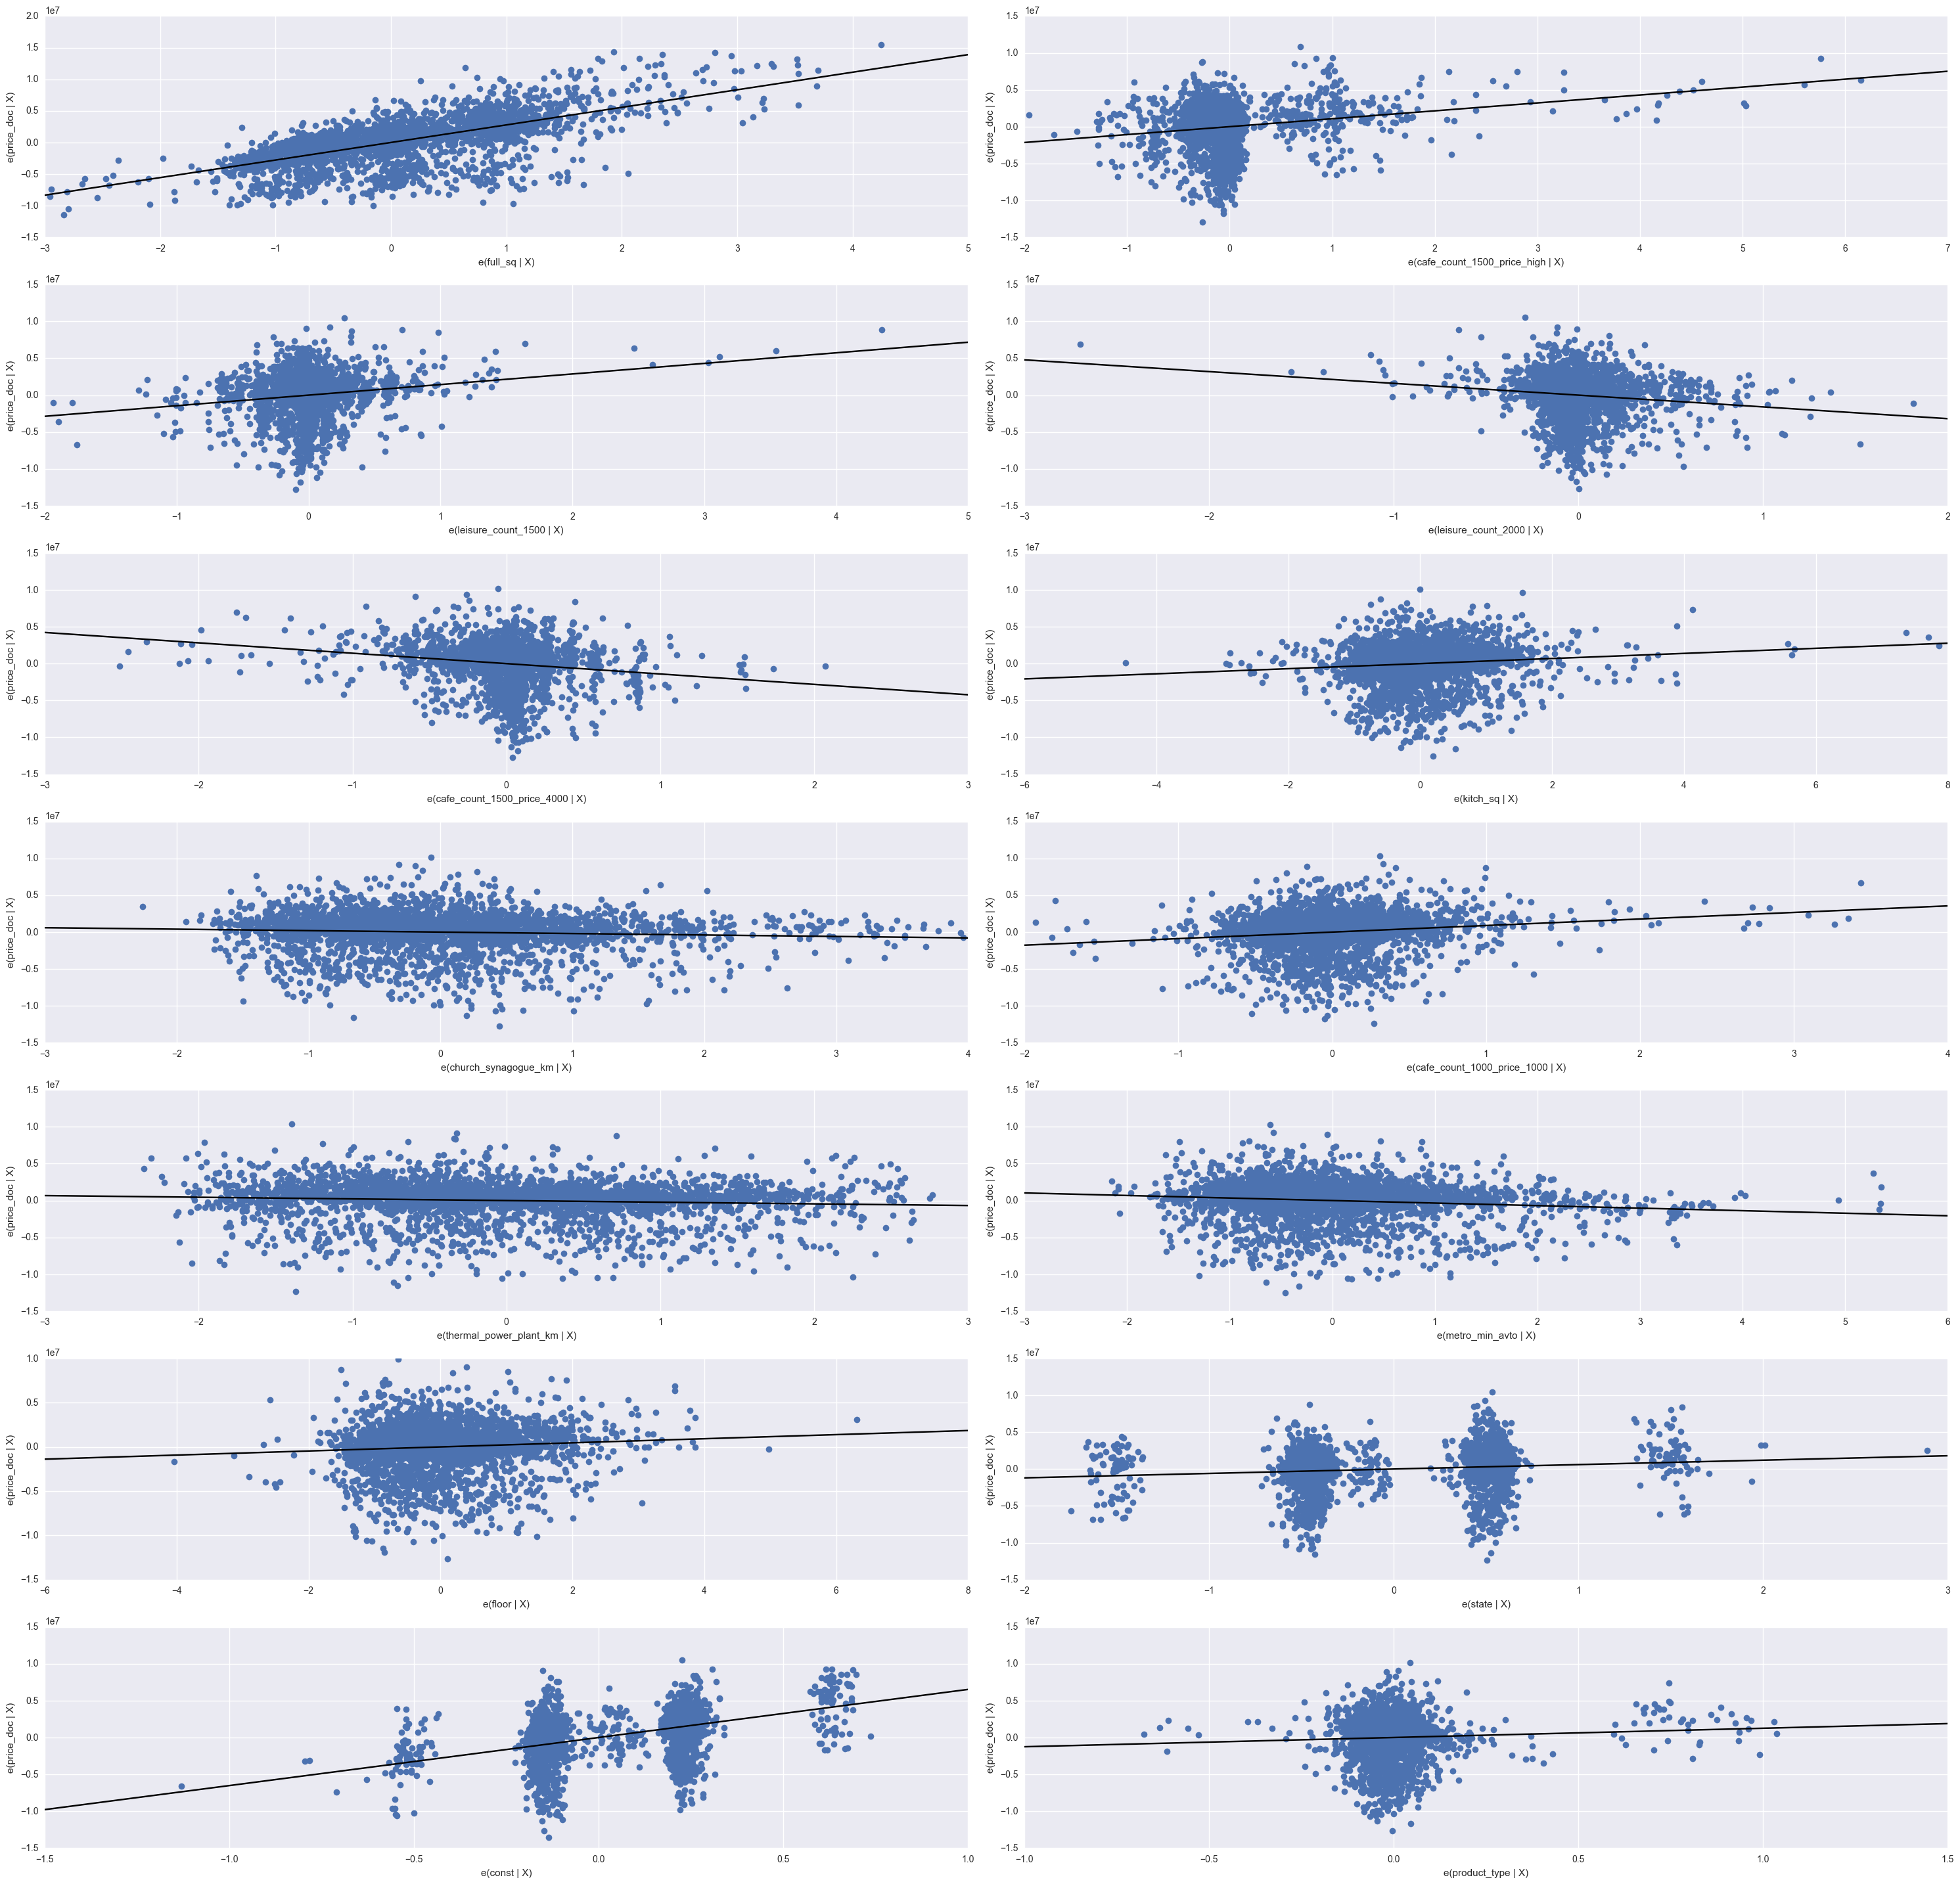

In [55]:
#Partial regression graph
fig = plt.figure(figsize = (30,30))
sm.graphics.plot_partregress_grid(result_train2, fig=fig)
fig.suptitle("")
plt.show()

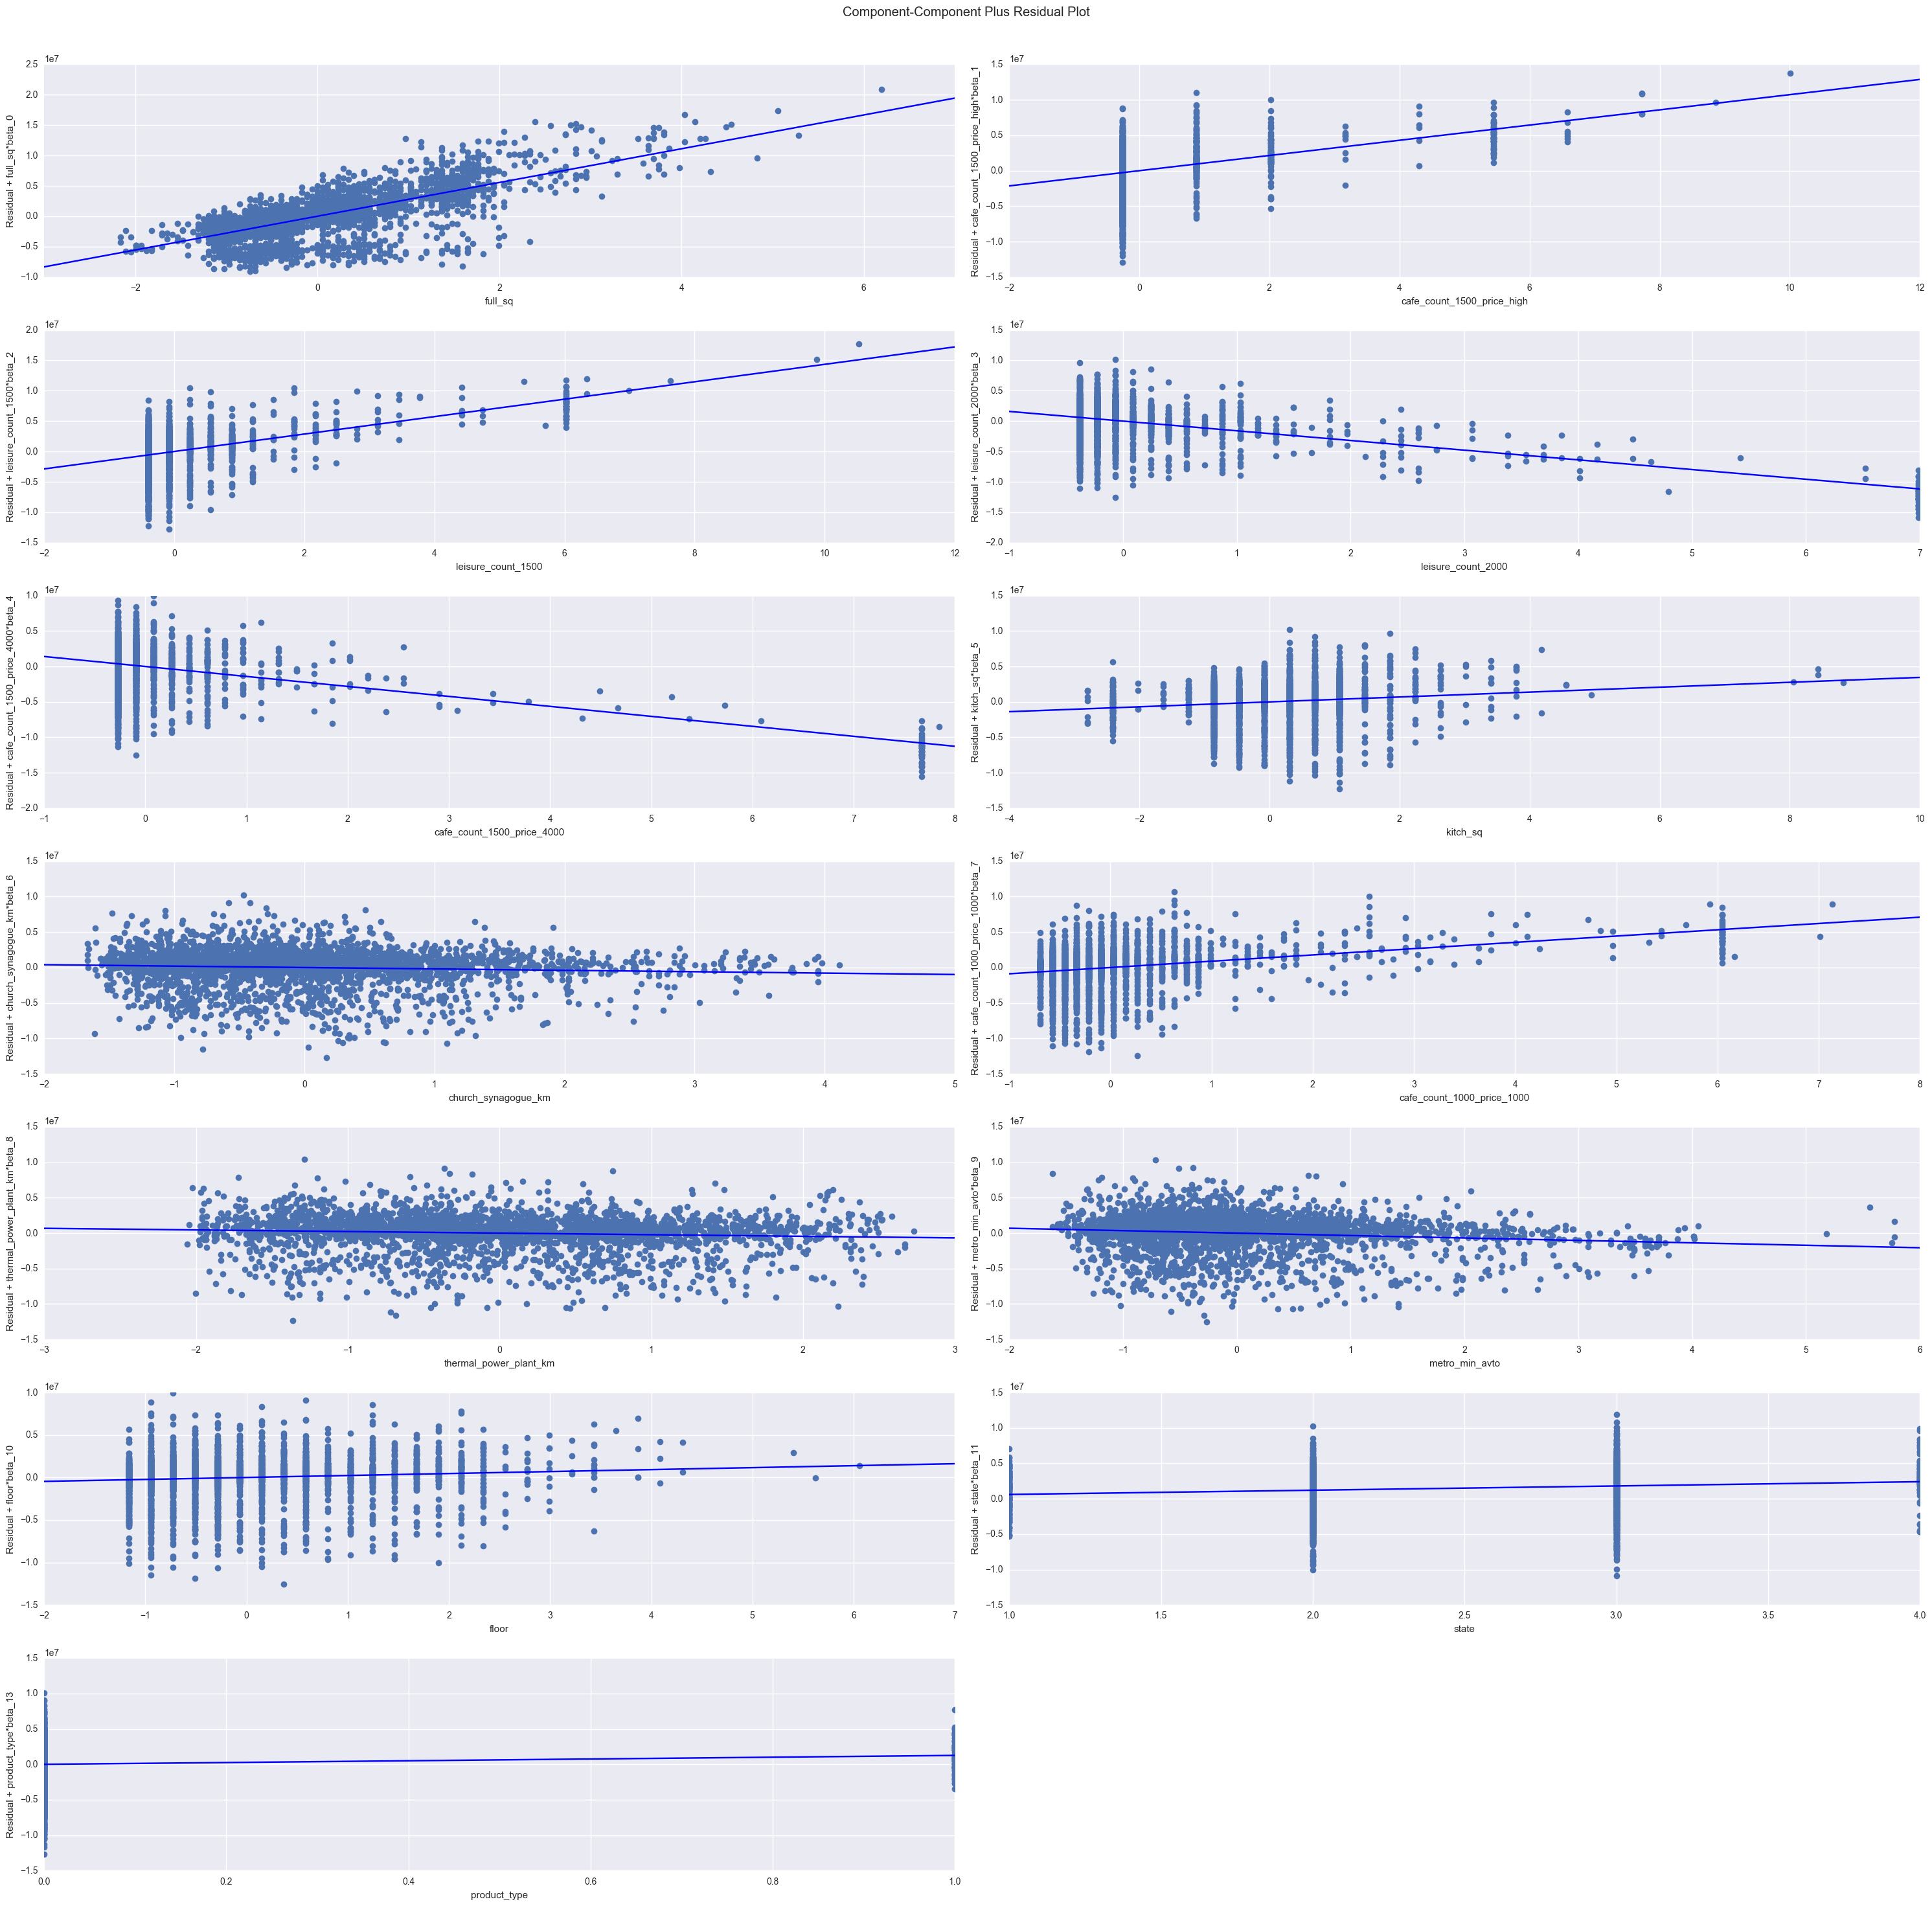

In [56]:
#CCPR plot
fig2 = plt.figure(figsize = (30,30))
sm.graphics.plot_ccpr_grid(result_train2, fig=fig2)
fig.suptitle("")
plt.show()

### Overfitting 을 확인하기 위해 Train/Test  정확도 비교 

* https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model -참조

In [57]:
train_pred = result_train2.predict(dfX3_train_sc)
train_r2_sk = r2_score(dfY_train, train_pred)
train_r2_sk

0.61021781668194919

In [58]:
test_pred = result_train2.predict(dfX3_test_sc)
test_r2_sk = r2_score(dfY_test, test_pred)
test_r2_sk

0.59635118466609138

In [59]:
dfY_train.shape

(3090, 1)

## Regularization Hyperparameter 최적화를 위한 KFold cross validation 적용

In [60]:
target = dfY_train.values.reshape(len(dfY_train), )

L1_wt_dict = {'Ridge':0, 'Elastic':0.5, 'Lasso':1}
alpha_list = [0.001, 0.01, 0.1, 1, 5]

r2_dict = {}
for r_type, L1_weight in L1_wt_dict.items():
    for alpha in alpha_list:
        kf = KFold(n = dfY_train.shape[0], n_folds = 5, random_state = 0) 
        r2_list = []
        for train, test in kf:
            model_kf = sm.OLS(dfY_train.iloc[train, :], dfX3_train_sc.iloc[train, :])
            result_kf = model_kf.fit_regularized(alpha = alpha, L1_wt = L1_weight)

            test_pred_kf = result_kf.predict(dfX3_train_sc.iloc[test, :])
            test_kf_r2 = r2_score(dfY_train.iloc[test, :], test_pred_kf)
            r2_list.append(test_kf_r2)
        print(r2_list)
        r2_mean = np.array([r2_list]).mean()
        r2_dict[r_type + ',' + str(alpha)] = r2_mean
r2_dict

[0.64585913290169816, 0.54399916459855147, 0.65016893256482522, 0.6236644489208012, 0.55486616627727603]
[0.63955814396493316, 0.53821973748420171, 0.64689315081524312, 0.62093408368670966, 0.55731575263126198]
[0.56898124957260021, 0.48566010310430086, 0.58502888884715154, 0.56480785999983307, 0.5222533505101159]
[0.29001230909893372, 0.30514288267591494, 0.33366232921963479, 0.33646145354965662, 0.33882761683921825]
[-0.59276901532795612, -0.43667312752687004, -0.38262523286028216, -0.43421318436921608, -0.37924108086656783]
[0.64628706175833939, 0.54447796368777757, 0.65019038175752264, 0.62358567540316834, 0.55416011684507749]
[0.64628706099135225, 0.54447796226203016, 0.65019038051470446, 0.62358567635855633, 0.55416011911767649]
[0.64628705332139691, 0.54447794800448801, 0.65019036808640662, 0.62358568591232588, 0.55416014184361995]
[0.64628697661339529, 0.54447780542239166, 0.65019024379191404, 0.62358578143903332, 0.55416036909842581]
[0.64628663550311138, 0.54447717157732156, 

{'Elastic,0.001': 0.60373720199847847,
 'Elastic,0.01': 0.6028381086850787,
 'Elastic,0.1': 0.57310447777896978,
 'Elastic,1': 0.43161897391546811,
 'Elastic,5': 0.0097570673858089936,
 'Lasso,0.001': 0.60374023989037717,
 'Lasso,0.01': 0.60374023984886394,
 'Lasso,0.1': 0.60374023943364752,
 'Lasso,1': 0.603740235273032,
 'Lasso,5': 0.60374021659550481,
 'Ridge,0.001': 0.60371156905263046,
 'Ridge,0.01': 0.60058417371646988,
 'Ridge,0.1': 0.54534629040680027,
 'Ridge,1': 0.3208213182766716,
 'Ridge,5': -0.44510432819017842}

# Lasso 회귀모형을 통한 회귀분석
- Lasso 모형이 다른 모형들에 비해 R squared 값이 안정적이고 높았다. Lasso 정규화와 정규화 계수 0.1로 추가 OLS 분석진행

In [61]:
'''Regularized OLS run to prevent overfitting'''
model_train_lasso = sm.OLS(dfY_train, dfX3_train_sc)
result_train_lasso = model_train_lasso.fit_regularized(alpha = 0.1, L1_weight = 1)
print(result_train_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     370.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:00:19   Log-Likelihood:                -50108.
No. Observations:                3090   AIC:                         1.002e+05
Df Residuals:                    3076   BIC:                         1.003e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [62]:
train_pred = result_train_lasso.predict(dfX3_train_sc)
train_r2_sk = r2_score(dfY_train, train_pred)
train_r2_sk

0.61021781668185926

In [63]:
test_pred = result_train_lasso.predict(dfX3_test_sc)
test_r2_sk = r2_score(dfY_test, test_pred)
test_r2_sk

0.59635121534369451

# 자연로그 적용 변수변환

*  https://stackoverflow.com/questions/42496508/histogram-on-pandas-column - 참조
* https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va - 참조

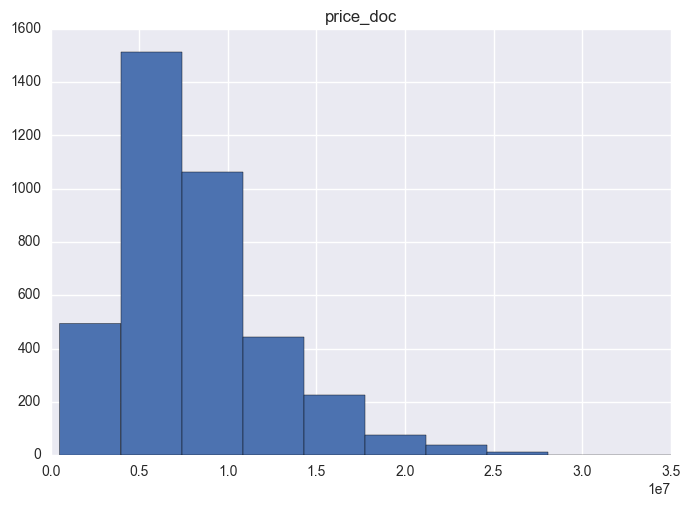

In [64]:
dfY_idx.hist(column = 'price_doc')
plt.show()

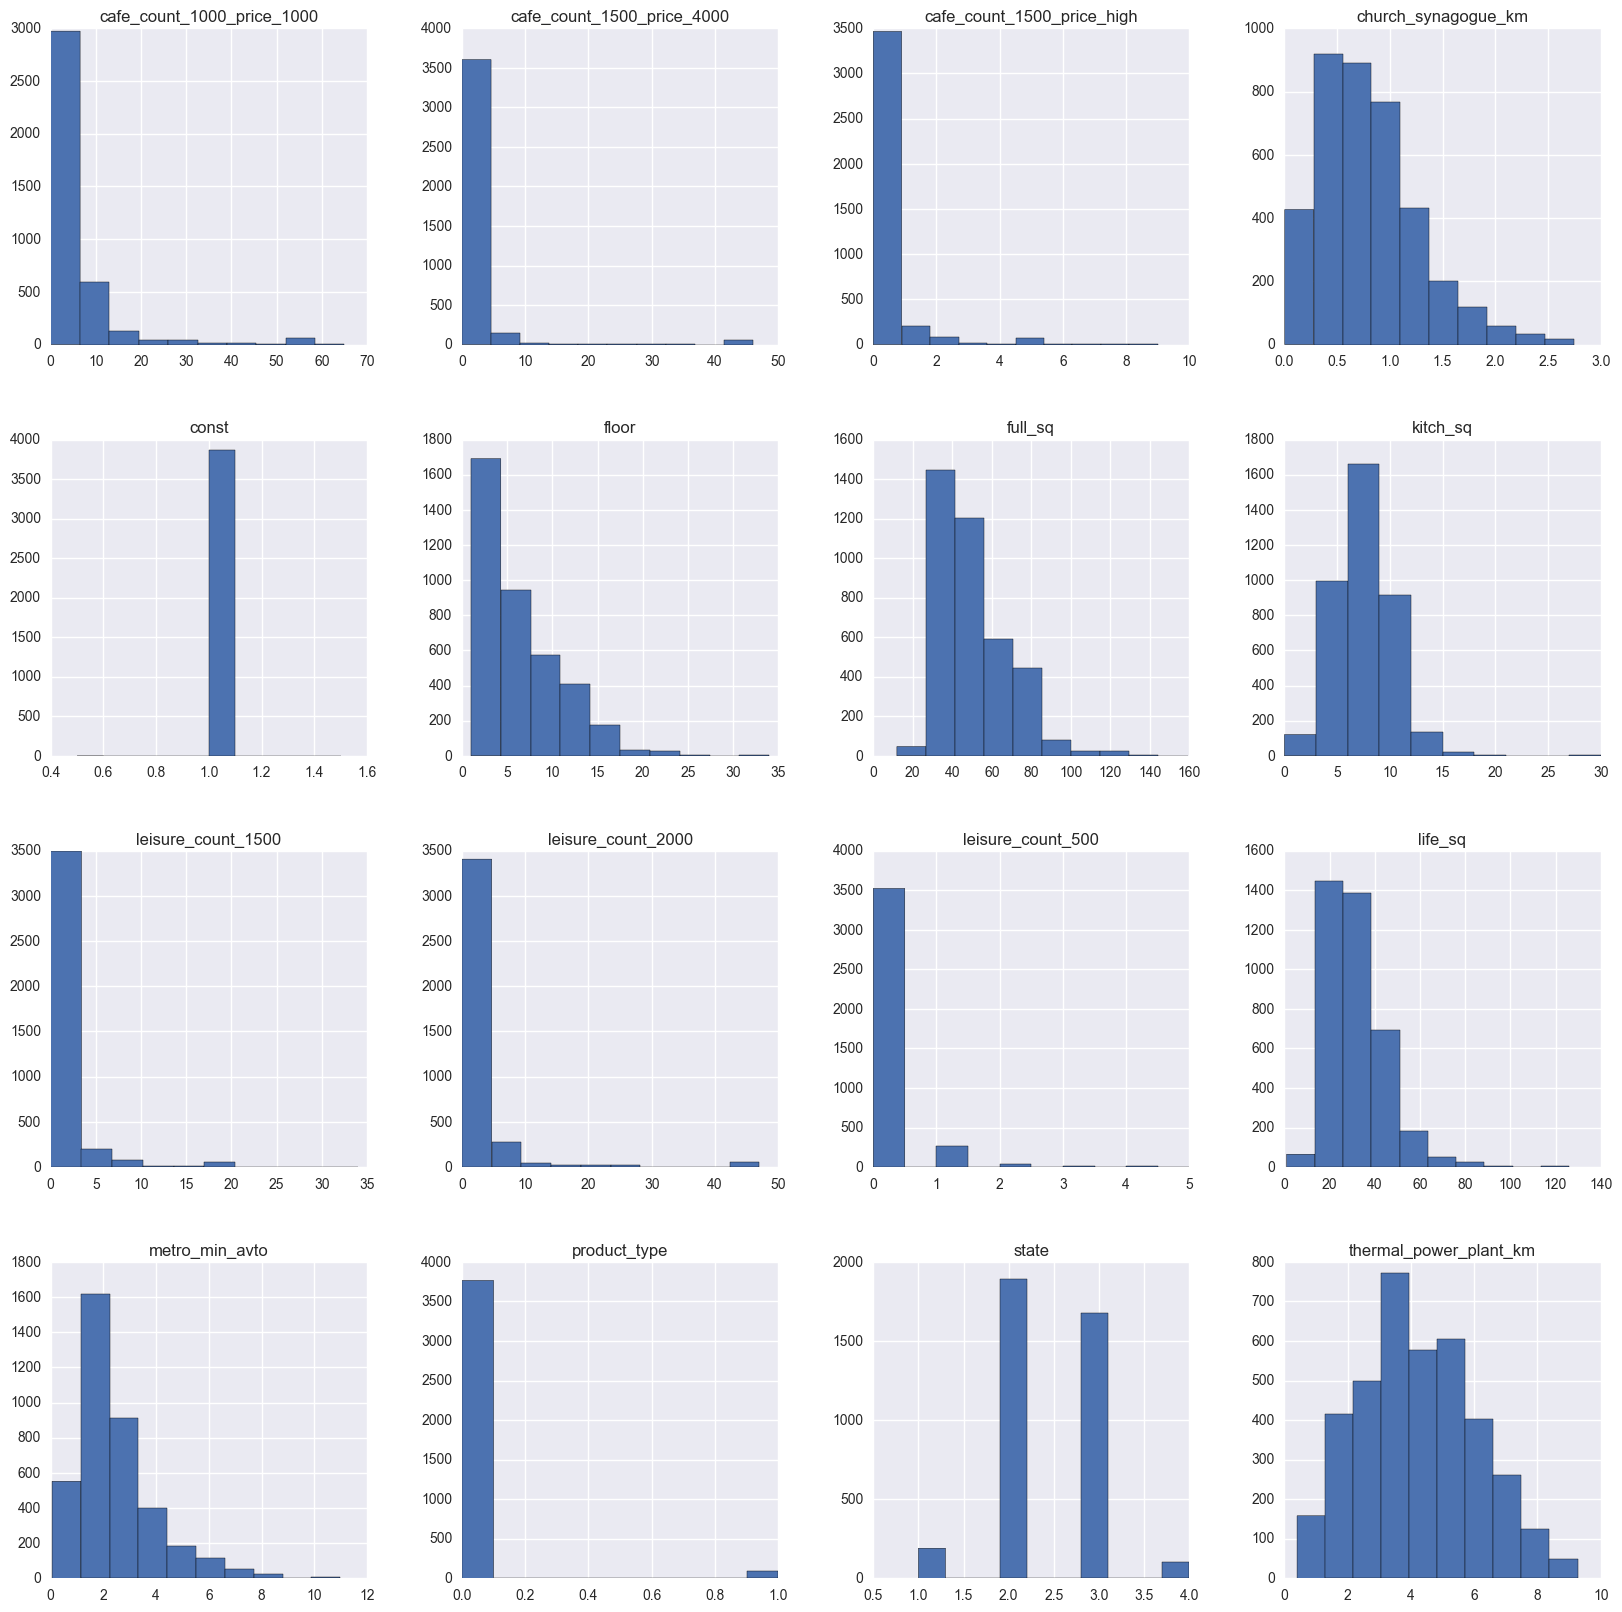

In [65]:
#Log plot of features before scaling. dfX3_idx_c is the feature matrix right after outlier extraction
#and before scaling & data split
dfX3_idx_c.hist(figsize = (20, 20))
plt.show()

In [66]:
dfX3_idx_c.head()

,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,state,cafe_count_1500_price_4000,life_sq,const,kitch_sq,church_synagogue_km,product_type,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500
1,77.0,2.0,1.0,1.0,2.0,5.0,50.0,1,8.0,0.897687,0.0,7.0,4.060103,2.003856,3.0,0.0
2,31.0,0.0,0.0,0.0,3.0,3.0,21.0,1,5.0,0.210790,0.0,3.0,2.951373,3.294727,5.0,0.0
3,43.0,0.0,0.0,1.0,2.0,0.0,27.0,1,5.0,0.438949,0.0,4.0,3.490974,1.499267,1.0,0.0
4,46.0,0.0,0.0,0.0,3.0,2.0,29.0,1,5.0,2.397977,0.0,3.0,1.826684,4.933331,9.0,0.0
5,38.0,0.0,0.0,1.0,2.0,1.0,24.0,1,5.0,0.832129,0.0,7.0,2.940426,1.605832,4.0,0.0


### 한쪽으로 치우쳐진 정규분포성을 가진 인자:  church_synagogue_km, full_sq, life_sq, metro_min_avto

# 해당인자에 자연로그 적용

In [67]:
natural_log_list = ['full_sq', 'metro_min_avto', 'church_synagogue_km']
dfX3_idx_c.loc[:, natural_log_list] = np.log(dfX3_idx_c.loc[:, natural_log_list])

In [68]:
dfX3_idx_c.head()

,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,state,cafe_count_1500_price_4000,life_sq,const,kitch_sq,church_synagogue_km,product_type,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500
1,4.343805,2.0,1.0,1.0,2.0,5.0,50.0,1,8.0,-0.107933,0.0,7.0,4.060103,0.695073,3.0,0.0
2,3.433987,0.0,0.0,0.0,3.0,3.0,21.0,1,5.0,-1.556895,0.0,3.0,2.951373,1.192323,5.0,0.0
3,3.761200,0.0,0.0,1.0,2.0,0.0,27.0,1,5.0,-0.823373,0.0,4.0,3.490974,0.404977,1.0,0.0
4,3.828641,0.0,0.0,0.0,3.0,2.0,29.0,1,5.0,0.874626,0.0,3.0,1.826684,1.596014,9.0,0.0
5,3.637586,0.0,0.0,1.0,2.0,1.0,24.0,1,5.0,-0.183768,0.0,7.0,2.940426,0.473642,4.0,0.0


In [69]:
dfX3_idx_c.shape

(3863, 16)

In [70]:
dfX3_desc = dfX3_idx_c.describe()
dfX3_desc

,full_sq,cafe_count_1500_price_high,leisure_count_1500,leisure_count_2000,state,cafe_count_1500_price_4000,life_sq,const,kitch_sq,church_synagogue_km,product_type,cafe_count_1000_price_1000,thermal_power_plant_km,metro_min_avto,floor,leisure_count_500
count,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.0,3863.000000,3863.000000,3863.00000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000
mean,3.859373,0.237121,1.273104,2.501424,2.438778,1.600052,30.673570,1.0,7.200621,-0.430097,0.02511,5.852964,4.236188,0.716867,6.265856,0.121926
std,0.331366,0.907246,3.132863,6.526878,0.631323,5.842111,13.298211,0.0,2.584137,0.699316,0.15648,8.474632,1.820833,0.610358,4.513400,0.463469
min,2.484907,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.0,0.000000,-5.722907,0.00000,0.000000,0.400563,-2.984116,1.000000,0.000000
25%,3.610918,0.000000,0.000000,0.000000,2.000000,0.000000,20.000000,1.0,5.000000,-0.832871,0.00000,2.000000,2.929126,0.392115,3.000000,0.000000
50%,3.806662,0.000000,0.000000,1.000000,2.000000,0.000000,28.000000,1.0,7.000000,-0.311984,0.00000,4.000000,4.084628,0.719605,5.000000,0.000000
75%,4.077537,0.000000,1.000000,2.000000,3.000000,1.000000,38.500000,1.0,9.000000,0.047704,0.00000,6.000000,5.556403,1.110113,9.000000,0.000000
max,5.068904,9.000000,34.000000,47.000000,4.000000,46.000000,126.000000,1.0,30.000000,1.009192,1.00000,65.000000,9.266473,2.396175,34.000000,5.000000


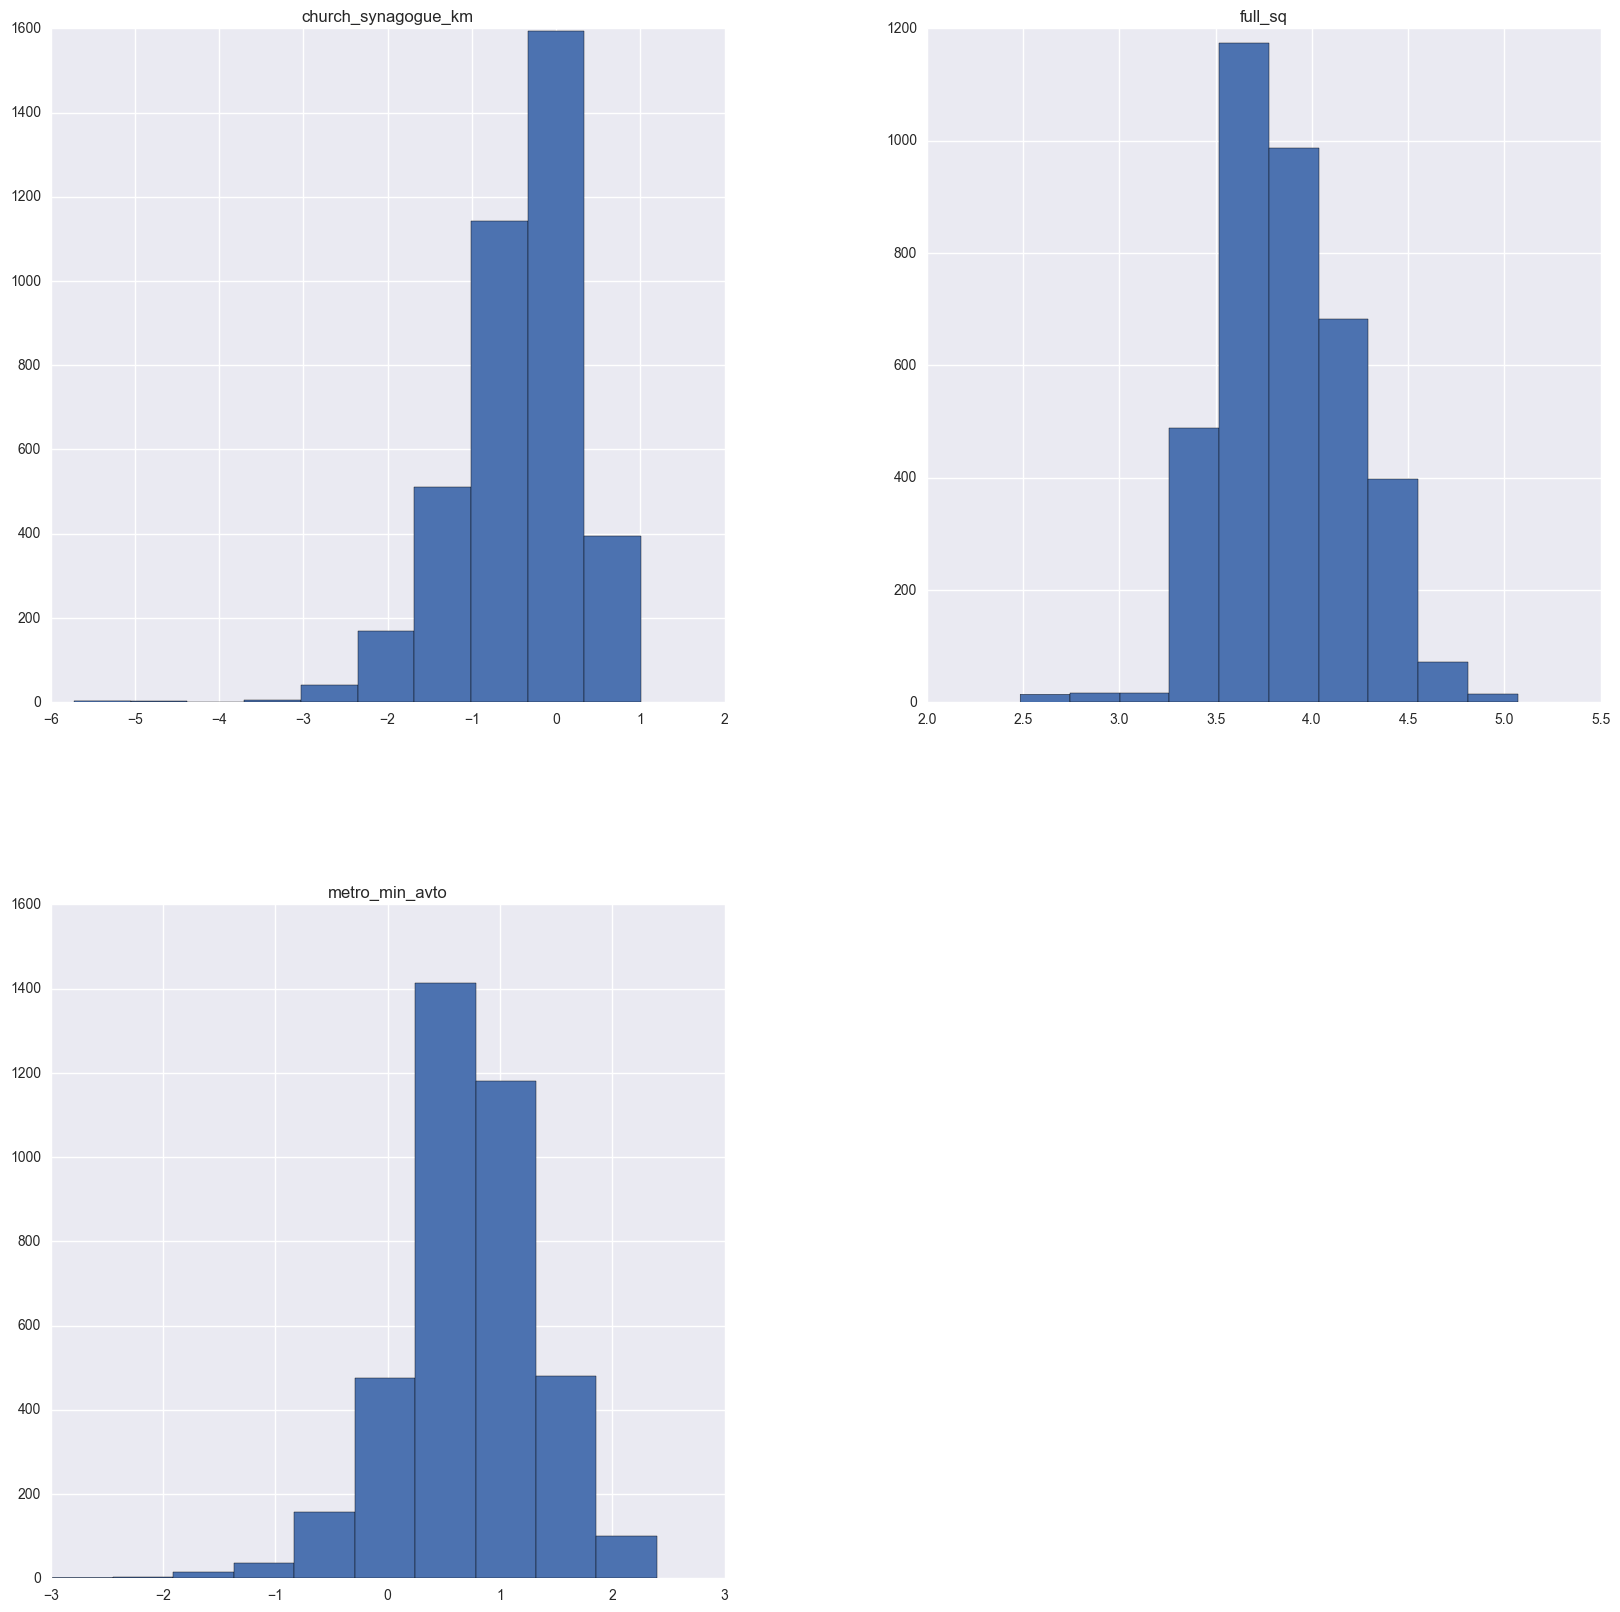

In [71]:
dfX3_idx_c.hist(column = natural_log_list, figsize = (20, 20))
plt.show()

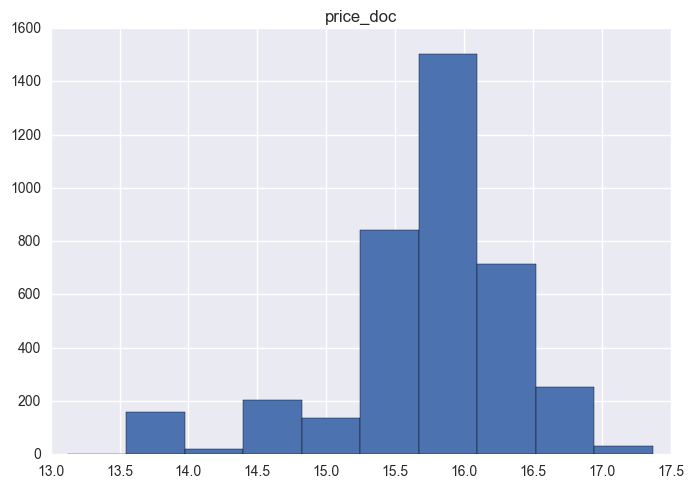

In [72]:
dfY_idx_log = np.log(dfY_idx)
dfY_idx_log.hist()
plt.show()

# 자연로그 변환 인자 OLS 적용

In [73]:
model_log = sm.OLS(dfY_idx, dfX3_idx_c)
result_log = model_log.fit()
print(result_log.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     341.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:00:24   Log-Likelihood:                -62845.
No. Observations:                3863   AIC:                         1.257e+05
Df Residuals:                    3847   BIC:                         1.258e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

In [74]:
model_log2 = sm.OLS(dfY_idx_log, dfX3_idx_c)
result_log2 = model_log2.fit()
print(result_log2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     123.2
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          1.92e-313
Time:                        00:00:24   Log-Likelihood:                -3024.6
No. Observations:                3863   AIC:                             6081.
Df Residuals:                    3847   BIC:                             6181.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
full_sq             

# Lasso 모델을 통해 얻어진 예측값 이용해, train과 test 각각 RMSE값 계산

In [76]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(train_pred, dfY_train)**(1/2)
rmse_test = mean_squared_error(test_pred, dfY_test)**(1/2)

print('RMSE for the training set is {}, RMSE for the test set is {}'.format(rmse_train, rmse_test))

RMSE for training set is 2668885.012882389, RMSE for test set is 2774035.805485537


In [83]:
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [84]:
rmsle_train = rmsle(train_pred, np.array(dfY_train))
rmsle_test = rmsle(test_pred, np.array(dfY_test))

print('RMSLE for the training set is {}, RMSLE for the test set is {}'.format(rmsle_train, rmsle_test))

RMSLE for the training set is [ 0.55336012], RMSLE for the test set is [ 0.52935886]


# 결론

## 1% Confidence Interval을 이용한 P-Value 필터링 적용결과:
1) R^2_adj_train = 0.609

2) R^2_adj_test = 0.596

3) 예측식 인자 갯수: 14개 (Bias값 포함)

4) 자연로그 적용을 통한 개선은 없었음

## 추가 검토 사항

1) Feature Selection Algorithm -> SBS (Sequential Backward Selection), Random Forest, Lasso Regularization

2) Feature Cleaning: Kaggle자료 검토결과 추가 feature cleaning 가능 예) living sq > full sq보다 큰 경우 데이터 처리